In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import matplotlib


import matplotlib.pylab as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import argparse
import cv2
import argparse
import random
import pickle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [3]:
!pip install q keras==2.3.0
import keras
keras.__version__

     |████████████████████████████████| 378kB 3.9MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


Using TensorFlow backend.


'2.3.0'

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
first_letters =  'ABCDEF'
second_numbers = '120'
last_letters = 'QWOPZXML'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3
    
print(get_random_string())

CDBE1XLQ


In [5]:
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
random_sequences[1:5]

['BCBD2ZOL', 'EAEA2LWW', 'CFED2MWO', 'ACCA1ZOZ']

In [0]:
#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

In [0]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

In [0]:
# add some anomalies to our list
random_sequences.extend(['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF'])
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)
# mix everything up
np.random.shuffle(encoded_seqs)

In [9]:
print(random_sequences[10])
print(encoded_seqs[10])
encoded_seqs.shape

FDCF1WQW
[31 29 27 27 54 52 41 41]


(25005, 8)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
X_train = scaled_seqs[:20000]
X_test = scaled_seqs[20000:]

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 20000 samples, validate on 5005 samples
Epoch 1/30
20000/20000 [==============================] - 1s 31us/step - loss: 0.1164 - accuracy: 0.0667 - val_loss: 0.0649 - val_accuracy: 0.1566
Epoch 2/30
20000/20000 [==============================] - 0s 13us/step - loss: 0.0512 - accuracy: 0.2482 - val_loss: 0.0399 - val_accuracy: 0.3131
Epoch 3/30
20000/20000 [==============================] - 0s 13us/step - loss: 0.0316 - accuracy: 0.5601 - val_loss: 0.0250 - val_accuracy: 0.6645
Epoch 4/30
20000/20000 [==============================] - 0s 14us/step - loss: 0.0219 - accuracy: 0.7056 - val_loss: 0.0193 - val_accuracy: 0.7465
Epoch 5/30
20000/20000 [==============================] - 0s 14us/step - loss: 0.0179 - accuracy: 0.7404 - val_loss: 0.0165 - val_accuracy: 0.7471
Epoch 6/30
20000/20000 [==============================] - 0s 13us/step - loss: 0.0156 - accuracy: 0.7463 - val_loss: 0.0146 - val_accuracy: 0.7451
Epoch 7/30
20000/20000 [==============================] - 0s 14us/ste

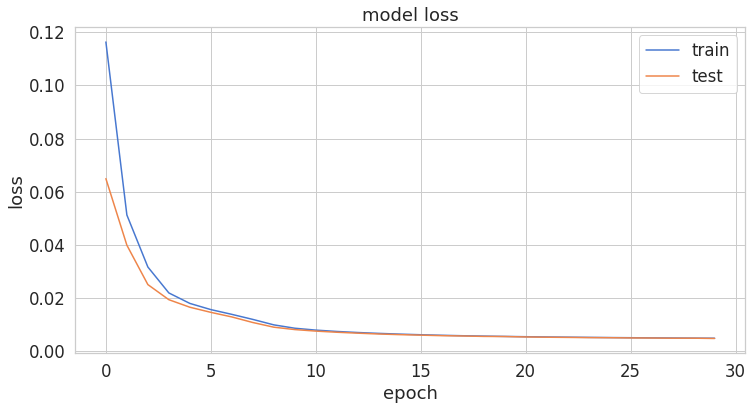

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [14]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 0.1599069184503606


In [15]:
#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse
display(seqs_ds)

,0,MSE
0,CBEB2PLQ,0.002474
1,BCBD2ZOL,0.001949
2,EAEA2LWW,0.004414
3,CFED2MWO,0.002431
4,ACCA1ZOZ,0.004013
...,...,...
25000,XYDC2DCA,0.214226
25001,TXSX1ABC,0.361446
25002,RNIU4XRE,0.163756
25003,AABDXUEI,0.017972


In [16]:
mse_threshold = np.quantile(seqs_ds['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.15990692643255727


In [17]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.iloc[25000:]

Num of MSE outlier:3


,0,MSE,MSE_Outlier
25000,XYDC2DCA,0.214226,1
25001,TXSX1ABC,0.361446,1
25002,RNIU4XRE,0.163756,1
25003,AABDXUEI,0.017972,0
25004,SDRAC5RF,0.156064,0


In [22]:
#Get more sample data
random_sequences_sample = [get_random_string() for i in range(2)]
random_sequences_sample.extend(['PQRC@DCA', 'MQKSX1BC'])
seqs_ds = pd.DataFrame(random_sequences_sample)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse
display(seqs_ds)

,0,MSE
0,AACF2MPL,0.008748
1,CDDC2PWP,0.006942
2,PQRC@DCA,0.300045
3,MQKSX1BC,0.323572
